# SPNC thermals
Code for experimenting with the effects of thermal variation on ML performance

Set up imports:

In [16]:
"""
Import handeling and Dependancy info

Local Dependancies
------------------
machine_learning_library  : v0.1.2
    This repository will need to be on your path in order to work.
    This is achieved with repo_tools module and a path find function
    Add to the searchpath and repos tuples if required


"""

import numpy as np
import matplotlib.pyplot as plt

# Sort out relative paths
import sys
from pathlib import Path
repodir = Path('..').resolve()
try:
    sys.path.index(str(repodir))
except ValueError:
    sys.path.append(str(repodir))

#tuple of Path variables
searchpaths = (Path.home() / 'repos', )
#tuple of repos
repos = ('machine_learning_library',)

# local imports
from SPNC import spnc
#ML specific
from SPNC.deterministic_mask import fixed_seed_mask, max_sequences_mask
import SPNC.repo_tools
SPNC.repo_tools.repos_path_finder(searchpaths, repos) #find ml library
from single_node_res import single_node_reservoir
import ridge_regression as RR
from linear_layer import *
from mask import binary_mask
from utility import *
from NARMA10 import NARMA10
from sklearn.metrics import classification_report

Establish shared parameters

In [70]:
'''
NARMA10 response
'''

figurewidth = 3.37*2.5
figureaspect = 2/3
figureheight = figurewidth*figureaspect

# NARMA parameters
Ntrain = 100
Ntest = 50

# Net Parameters
Nvirt = 5
m0 = 0.003
bias = True

# Misc parameters
seed_NARMA = 1234
fixed_mask = False
spacer = 5

theta = 0.4
gamma = 0.132
delay_feedback = 0
params = {'theta': theta, 'gamma' : gamma,'delay_feedback' : delay_feedback,'Nvirt' : Nvirt}


def get_res(h=0.4,theta_H=90,k_s_0=0,phi=45,beta_prime=20):
    res = spnc.spnc_anisotropy(h,theta_H,k_s_0,phi,beta_prime)
    transform = res.gen_signal_fast_delayed_feedback

    return res, transform

base_beta_prime = 20
spnres, transform = get_res(beta_prime=base_beta_prime)
spnreshigher, transformhigher = get_res(beta_prime=base_beta_prime)

Data and net setup

seed NARMA: 1234
Samples for training:  100
Samples for test:  50
Nin = 1 , Nout =  100 , Nvirt =  5


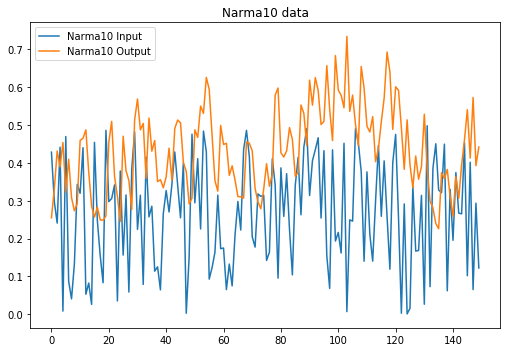

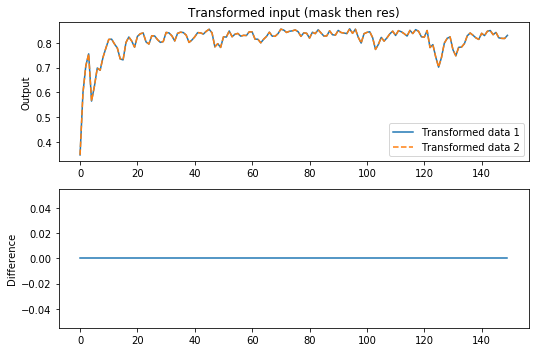

In [71]:
# Lets get into it
print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)

fig, ax = plt.subplots(1,figsize=[figurewidth,figureheight])
ax.plot(u)
ax.plot(d)
ax.legend(['Narma10 Input','Narma10 Output'])
ax.set_title('Narma10 data')

transform_1 = get_res(beta_prime=base_beta_prime)[1]
transform_2 = get_res(beta_prime=base_beta_prime)[1]

transformed_1 = transform_1(u,params)
transformed_2 = transform_2(u,params)

fig,ax = plt.subplots(2,figsize=[figurewidth,figureheight])
ax[0].plot(transformed_1)
ax[0].plot(transformed_2,linestyle='dashed')
ax[0].set_title('Transformed input (mask then res)')
ax[0].legend(['Transformed data 1','Transformed data 2'])
ax[0].set_ylabel('Output')
ax[1].plot(transformed_1-transformed_2)
ax[1].set_ylabel('Difference')

x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

Training and testing:

Using Nthreads =  1
Seed Training: 1234
l= 4.5399929762484854e-05 0.007134081270068623
l= 5.017468205617528e-05 0.0072134992491780184
l= 5.5451599432176945e-05 0.007289591957327498
l= 6.128349505322202e-05 0.007362113016912633
l= 6.772873649085378e-05 0.007430877532256665
l= 7.485182988770046e-05 0.007495758513213861
l= 8.272406555663209e-05 0.007556682243939621
l= 9.142423147817311e-05 0.007613622956298488
l= 0.00010103940183709307 0.0076665971301262984
l= 0.00011166580849011438 0.007715657694673408
l= 0.0001234098040866791 0.007760888352093265
l= 0.0001363889264820109 0.007802398190346699
l= 0.00015073307509547596 0.007840316702680141
l= 0.00016658581098763264 0.00787478928648987
l= 0.00018410579366757822 0.0079059732573292
l= 0.00020346836901064308 0.007934034384747221
l= 0.000224867324178847 0.007959143935276096
l= 0.00024851682710795055 0.007981476194055847
l= 0.0002746535699721406 0.008001206429146845
l= 0.0003035391380788646 0.00801850926075704
l= 0.00033546262790250947 0.008033

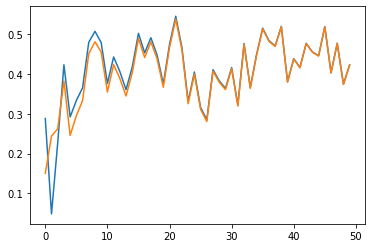

Error and NRMSE for normal testing 0.013488838496386076 1.0216478176128547
Error and NRMSE for higher temp testing 0.015128482994675438 1.08196104558003


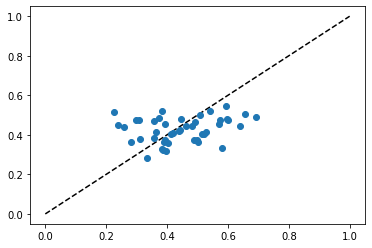

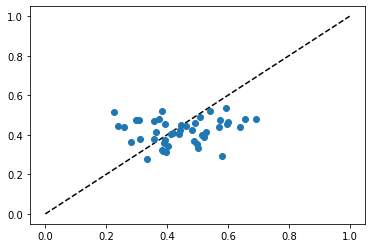

In [19]:
# Training
S_train, J_train = snr.transform(x_train,params)
np.size(S_train)
seed_training = 1234
RR.Kfold_train(net,S_train,y_train,10, quiet = False)

# Testing
S_test, J_test = snr.transform(x_test,params)
#test with the other transform...
snr.res = transformhigher
S_test_higher, J_test_higher = snr.transform(x_test,params)


print("Spacer NRMSE:"+str(spacer))
pred = net.forward(S_test)
pred_higher = net.forward(S_test_higher)
plt.plot(pred)
plt.plot(pred_higher)
plt.show()
np.size(pred)
error = MSE(pred[spacer:], y_test[spacer:])
predNRMSE = NRMSE(pred[spacer:], y_test[spacer:])
print('Error and NRMSE for normal testing', error, predNRMSE)

error_higher = MSE(pred_higher[spacer:], y_test[spacer:])
predNRMSE_higher = NRMSE(pred_higher[spacer:], y_test[spacer:])
print('Error and NRMSE for higher temp testing', error_higher, predNRMSE_higher)

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred[spacer:],'o')
plt.show()

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred_higher[spacer:],'o')
plt.show()